<a href="https://colab.research.google.com/github/ShaliniAnandaPhD/HarmonyLens/blob/main/Harmony_Lens_Module_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extracting The Data

## Setting up the News api to fetch data from different news sources

https://newsapi.org/docs/client-libraries/python

In [ ]:
!pip install newsapi-python newspaper3k googletrans==4.0.0-rc1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 91.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ..

In [ ]:
from newsapi import NewsApiClient
import json
from googletrans import Translator

In [ ]:
# Get articles from the news api for now - look at adding more sources later maybe
def gather_data_from_apis(add_text, lan):

  # providing the api key to access the news articles
  newsapi = NewsApiClient(api_key='d644c89c77824e5fbac3847cb7f7b07a')

  # Setting up a list of articles to get
  topics = ['peace + negotiations', 'diplomatic + relations',
            'conflict + resolution', 'treaty + talks',
            'pacification + efforts', 'mediation', 'peacemaking',
            'accord + discussions']

  #Setting up the translator
  translator = Translator()

  # creating an empty list to store these articles
  all_articles = []

  for topic in topics:
    topic+= add_text
    if topic != 'en':
      topic = translator.translate(topic, dest=lan).text
    articles = newsapi.get_everything(q=topic,
                                      language=lan,
                                      sort_by='relevancy')
    all_articles.extend(articles['articles'])

  # Creating empty list to store the data
  data = []

  # Iterating through the results to store the articles
  for article in all_articles:
    data.append({"title": article['title'],
                 "link": article['url'],
                 "published":article['publishedAt'],
                 "description":article['description'],
                 "content":article['content'],
                 "language": lan})
  return data



## Get data in different languages

In [ ]:
languages = ['en','fr', 'es', 'pt', 'ru']
# Usage
data = []
for lan in languages:
  dat = gather_data_from_apis(add_text = ' + russia + ukraine', lan = lan)
  data.extend(dat)

 ## Getting data about history

In [ ]:
historical_data = gather_data_from_apis(add_text = ' + russia + ukraine + history', lan = 'en')

## Remove the articles that were removed and are not translated or empty

In [ ]:
# Making some changes
data = [entry for entry in data if entry.get("title") != '[Removed]']
data = [article for article in data if all(value is not None for value in article.values())]
data = [article for article in data if isinstance(article['title'], str)]

## Create a function to translate the title column of all articles

In [ ]:
from googletrans import Translator

def translate_article_data(article):
    original_language = article['language'].lower()

    # Translate only if the original language is not English
    if original_language != 'en':
        translator = Translator()
        translated_title = translator.translate(article['title'], dest='en').text
    else:
        # If the original language is English, keep the original text
        translated_title = article['title']

    translated_data = {
        "title": translated_title,
        "link": article['link'],
        "published": article['published'],
        "description": article['description'],
        "content": article['content'],
        "language": original_language  # Target language is always English
    }

    return translated_data

## Translate all the data gathered from the api

In [ ]:
translated_articles = []

for article in data:
    translated_article_data = translate_article_data(article)
    if translated_article_data:  # Check if the translated data is not an empty dictionary
        translated_articles.append(translated_article_data)
# saving the data in the object data
data = translated_articles

In [ ]:
def save_data_to_file(data, filename):
    with open(filename, 'w') as file:
        json.dump(data, file, indent=4)
save_data_to_file(data,'output.json')
save_data_to_file(historical_data,'historical_output.json')

# Pre-processing the data for sentiment analysis

## Downloads necessary NLTK resources and defines a function for preprocessing text data.

In [ ]:
import nltk
import string
import json
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def preprocess_text_data(data):
    processed_data = []
    for item in data:
        # Extract text content from each item
        text = item.get('title', '')

        # Preprocess the data before tokenizing
        if not isinstance(text, str):
          text = str(text)

        # Remove HTML tags and convert to lowercase
        text = text.lower()

        # Remove punctuation and numbers
        text = ''.join([char for char in text if char not in
                        string.punctuation and not char.isdigit() and
                        char not in ["’", '“','”', "–",'‘']])

        # Tokenization
        tokens = word_tokenize(text)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]


        # Rejoin tokens into a string
        processed_text = ' '.join(tokens)

        #append to the dataset
        processed_data.append(processed_text)

    return processed_data

## Loading the saved data input and pre processing the data for analysis

In [ ]:
def load_data_from_file(filename):
    with open(filename, 'r') as file:
        return json.load(file)

# Load raw data from 'output.json'
raw_data = load_data_from_file('output.json')

# Preprocess the loaded data
processed_data = preprocess_text_data(raw_data)


In [ ]:
# Load raw data from 'output.json'
raw_data_hist = load_data_from_file('historical_output.json')

# Preprocess the loaded data
processed_data_hist = preprocess_text_data(raw_data_hist)
print(processed_data_hist)

['bitter wars long history solution sight', 'top world changing negotiations', 'mandelas support palestinians endures genocide case israel', 'predictions passé navigate focus whats plausible', 'friday january russias war ukraine news information ukraine', 'ukraine bet losers exzelensky aide', 'ps commentators predictions', 'state department press falsehoods facts', 'removed', 'ukraine nato must grind beat russia', 'wall street journal sets standard irresponsible journalism ukraine', 'ukraine podcast top ukraine podcasts', 'west defeated', 'russianturkish strategic cooperation new security environment', 'end mass atrocities gaza beyond', 'ukraines war narratives', 'ending much world war quarter population living places affected conflict', 'sergey karaganov russians real europeans west continent lost way', 'ukrainian tragedy might escalate armaggedon', 'wages neglect syria', 'wheres side russoukraine war discussion', 'international news stories defined', 'evisceration united nations secu

## Exploring the pre proccessed data to see what are the most recurring words

Top 10 Tokens and Frequencies:
ukraine: 208
russia: 118
war: 103
us: 58
peace: 49
russian: 47
world: 42
putin: 34
year: 34
says: 30


<ipython-input-15-ff275a811161>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Token', data=token_df.head(10), palette='viridis')


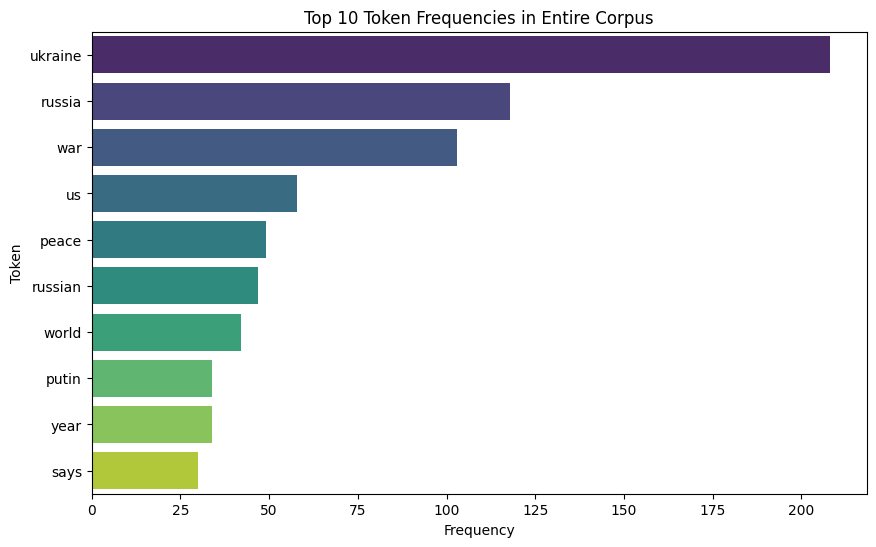

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

combined_text = ' '.join(processed_data)
tokens = word_tokenize(combined_text)


# Count token frequencies
token_counts = Counter(tokens)

# Display the most common tokens and their frequencies
most_common_tokens = token_counts.most_common(10)
print("Top 10 Tokens and Frequencies:")
for token, count in most_common_tokens:
    print(f"{token}: {count}")



# Convert token_counts to a DataFrame for easier plotting
token_df = pd.DataFrame(token_counts.most_common(), columns=['Token', 'Frequency'])

# Plot token frequencies
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Token', data=token_df.head(10), palette='viridis')
plt.title('Top 10 Token Frequencies in Entire Corpus')
plt.xlabel('Frequency')
plt.ylabel('Token')
plt.show()

In [ ]:
save_data_to_file(processed_data,'output_processed.json')

# Performing sentiment analysis to understand the public mood and tone.

## Importing pipline to use sentiment analysis model from hunggingface

In [ ]:
from transformers import pipeline
import torch

## Defining a function to analyse the sentiments in every article

In [ ]:
def perform_sentiment_analysis(data):
    """
    Perform sentiment analysis on a list of text strings.

    Args:
    data (list of str): A list of text strings to analyze.

    Returns:
    list of dict: A list of dictionaries containing the sentiment analysis results.
    """
    # Check if CUDA is available for faster processing
    device = 0 if torch.cuda.is_available() else -1

    # Initialize the sentiment analysis model pipeline
    # The model automatically defaults to a pre-trained sentiment analysis model
    sentiment_analysis = pipeline("sentiment-analysis", device=device)

    results = []
    for text in data:
        try:
            # Ensure text is a string
            if isinstance(text, str):
                # Perform sentiment analysis
                result = sentiment_analysis(text)
                results.append(result)
            else:
                results.append([{"label": "Error", "score": 0, "text": "Invalid input"}])
        except Exception as e:
            # Handle any errors encountered during analysis
            results.append([{"label": "Error", "score": 0, "text": str(e)}])

    return results


In [ ]:
# Assuming 'processed_data' is a list of text strings
sentiment_results = perform_sentiment_analysis(processed_data)

# # Print the results
# for idx, result in enumerate(sentiment_results):
#     print(f"Text {idx+1}: {processed_data[idx]}")
#     print(f"Sentiment: {result[0]['label']}, Score: {result[0]['score']:.2f}\n")


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

## Visualising the result

In [ ]:
import pandas as pd
df = pd.DataFrame(raw_data)
df['sentiment_score'] = [result[0]['score'] for result in sentiment_results]
df['sentiment_label'] = [result[0]['label'] for result in sentiment_results]
df['processed_text'] = [data for data in processed_data]
df['published'] = pd.to_datetime(df['published'])
df.info()
df[df['published'] == min(df['published'])]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   title            680 non-null    object             
 1   link             680 non-null    object             
 2   published        680 non-null    datetime64[ns, UTC]
 3   description      680 non-null    object             
 4   content          680 non-null    object             
 5   language         680 non-null    object             
 6   sentiment_score  680 non-null    float64            
 7   sentiment_label  680 non-null    object             
 8   processed_text   680 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(1), object(7)
memory usage: 47.9+ KB


,title,link,published,description,content,language,sentiment_score,sentiment_label,processed_text
21,Ukraine urged to invite Russia to take part in...,https://www.rt.com/news/589398-south-africa-uk...,2023-12-20 16:39:23+00:00,South Africa has advised Kiev to invite Moscow...,A negotiated outcome in the conflict between R...,en,0.972168,POSITIVE,ukraine urged invite russia take part peace talks


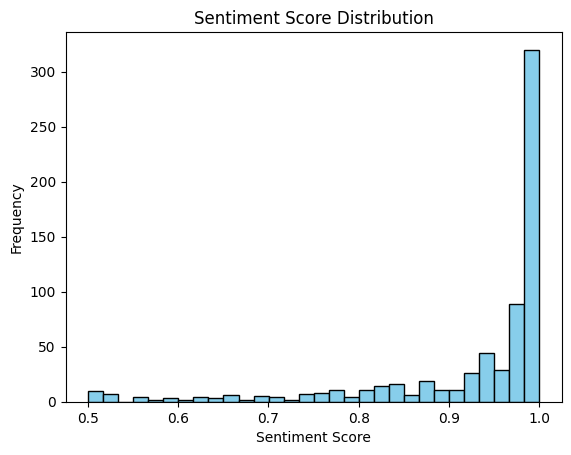

In [ ]:
import matplotlib.pyplot as plt
plt.hist(df['sentiment_score'], bins=30, color='skyblue', edgecolor='black')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

<ipython-input-22-c31ee3582b50>:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_weekly_language = df.groupby([df['published'].dt.to_period('W-Mon'), 'language']).mean()
<ipython-input-22-c31ee3582b50>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_weekly_language = df.groupby([df['published'].dt.to_period('W-Mon'), 'language']).mean()


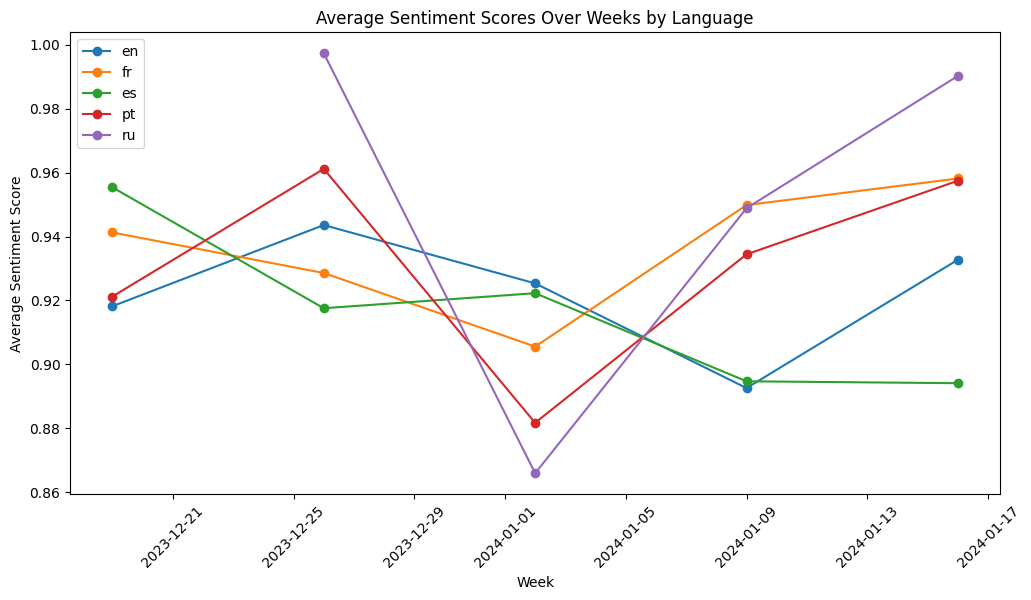

In [ ]:

df_weekly_language = df.groupby([df['published'].dt.to_period('W-Mon'), 'language']).mean()

# Plot sentiment scores over time by week and language
plt.figure(figsize=(12, 6))

# Iterate over unique languages and plot each separately
for language in df['language'].unique():
    subset_df = df_weekly_language.loc[df_weekly_language.index.get_level_values('language') == language]
    plt.plot(subset_df.index.get_level_values(0).to_timestamp(), subset_df['sentiment_score'], marker='o',
             linestyle='-', label=language)

plt.title('Average Sentiment Scores Over Weeks by Language')
plt.xlabel('Week')
plt.ylabel('Average Sentiment Score')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

#data
positive_sentences = df['processed_text'][df['sentiment_label'] == 'POSITIVE']
negative_sentences = df['processed_text'][df['sentiment_label'] == 'NEGATIVE']

# Tokenize and preprocess
positive_tokens = [word_tokenize(sentence.lower()) for sentence in positive_sentences]
negative_tokens = [word_tokenize(sentence.lower()) for sentence in negative_sentences]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from nltk import FreqDist

def count_word_pairs(sentences):
    word_pairs = []
    for sentence_tokens in sentences:
        word_pairs.extend(list(nltk.bigrams(sentence_tokens)))
    return FreqDist(word_pairs)

positive_word_pair_counts = count_word_pairs(positive_tokens)
negative_word_pair_counts = count_word_pairs(negative_tokens)

# Display most common word pairs in positive sentences
print("Most Common Word Pairs in Positive Sentences:")
print(positive_word_pair_counts.most_common(5))

# Display most common word pairs in negative sentences
print("\nMost Common Word Pairs in Negative Sentences:")
print(negative_word_pair_counts.most_common(5))

Most Common Word Pairs in Positive Sentences:
[(('war', 'ukraine'), 8), (('russia', 'ukraine'), 7), (('foreign', 'minister'), 5), (('ukraine', 'peace'), 5), (('peace', 'formula'), 5)]

Most Common Word Pairs in Negative Sentences:
[(('russia', 'ukraine'), 17), (('war', 'ukraine'), 12), (('ukraine', 'war'), 11), (('red', 'sea'), 9), (('exchange', 'prisoners'), 9)]


# Topic Modelling to find underlying themes in the data

In [ ]:
!pip install gensim

In [ ]:
from gensim import corpora, models
import gensim

def prepare_data_for_lda(processed_data):
    # Ensure that processed_data is not empty
    if not processed_data or not any(processed_data):
        return None, None

    token_data = []
    for text in processed_data:
      tokens = word_tokenize(text)
      tokens = [word.lower() for word in tokens]
      token_data.append(tokens)

    dictionary = corpora.Dictionary(token_data)
    corpus = [dictionary.doc2bow(text) for text in token_data if text]
    return corpus, dictionary

# Function to run LDA model
def run_lda_model(processed_data, num_topics=5):
    corpus, dictionary = prepare_data_for_lda(processed_data)

    # Check if corpus and dictionary are valid
    if not corpus or not dictionary:
        print("Error: Corpus or dictionary is empty. Cannot run LDA.")
        return None

    try:
        lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                                    num_topics=num_topics,
                                                    id2word=dictionary, passes=15)
        return lda_model
    except ValueError as e:
        print("Error running LDA model:", e)
        return None

# Running the LDA model
lda_model = run_lda_model(processed_data)

# Displaying topics if the model is valid
if lda_model:
    topics = lda_model.print_topics(num_words=4)
    for topic_id, topic in lda_model.print_topics():
      print(f"Topic {topic_id + 1}: {topic}")
else:
    print("No LDA model to display topics.")

Topic 1: 0.032*"ukraine" + 0.013*"russia" + 0.011*"foreign" + 0.011*"new" + 0.010*"putin" + 0.010*"year" + 0.007*"minister" + 0.007*"russian" + 0.007*"top" + 0.007*"eu"
Topic 2: 0.036*"ukraine" + 0.018*"war" + 0.015*"peace" + 0.014*"says" + 0.013*"russia" + 0.008*"west" + 0.006*"russian" + 0.006*"international" + 0.006*"kremlin" + 0.005*"nato"
Topic 3: 0.024*"ukraine" + 0.019*"war" + 0.018*"peace" + 0.010*"ukrainian" + 0.010*"russia" + 0.008*"gaza" + 0.008*"putin" + 0.007*"south" + 0.007*"moscow" + 0.006*"year"
Topic 4: 0.018*"us" + 0.014*"ukraine" + 0.014*"war" + 0.013*"russian" + 0.011*"world" + 0.011*"russia" + 0.008*"global" + 0.006*"economy" + 0.006*"great" + 0.006*"security"
Topic 5: 0.037*"ukraine" + 0.034*"russia" + 0.019*"exchange" + 0.015*"war" + 0.015*"prisoners" + 0.013*"us" + 0.010*"west" + 0.009*"world" + 0.006*"missiles" + 0.006*"hundreds"


In [ ]:
!pip install matplotlib wordcloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


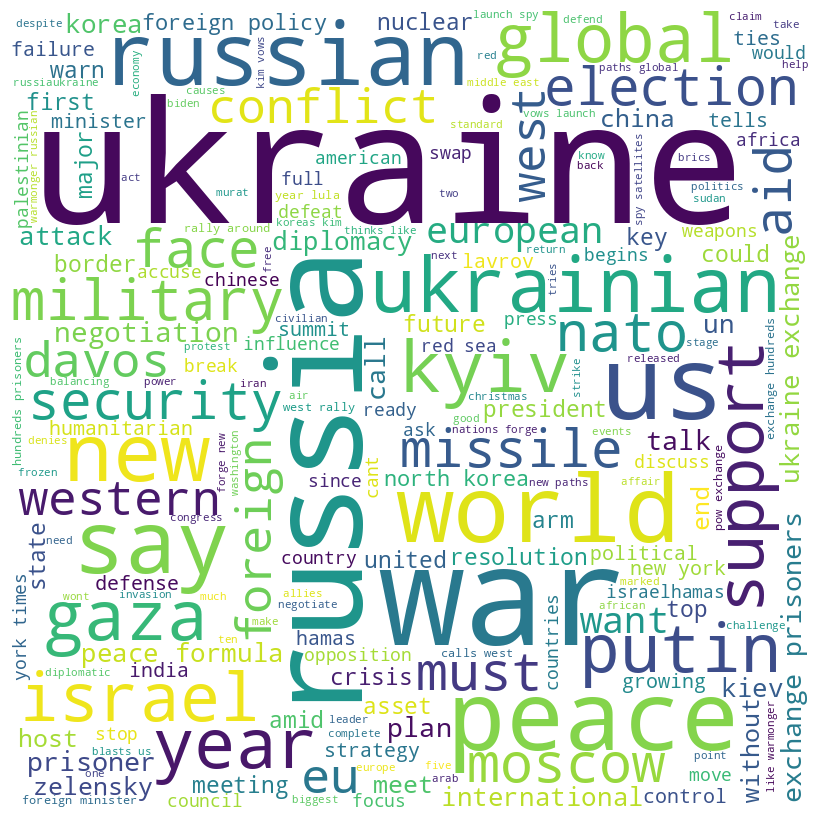

In [ ]:
import nltk
from nltk.corpus import stopwords

# Ensure nltk resources are available
nltk.download('stopwords')

def wordcloud_generate(processed_data):
  try:
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt

    # Generate a word cloud
    all_words = ''.join([word for text in processed_data for word in text])

    # Check if there are words to generate a word cloud
    if not all_words.strip():
        raise ValueError("No words available for generating a word cloud.")

    wordcloud = WordCloud(width=800, height=800,
                          background_color='white',
                          stopwords=set(stopwords.words('english')),
                          min_font_size=10).generate(all_words)

    # Plot the WordCloud image
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

  except ImportError as e:
    print("Required libraries are not installed:", e)
  except ValueError as e:
    print("Error:", e)
  except Exception as e:
    print("An unexpected error occurred:", e)

wordcloud_generate(processed_data)

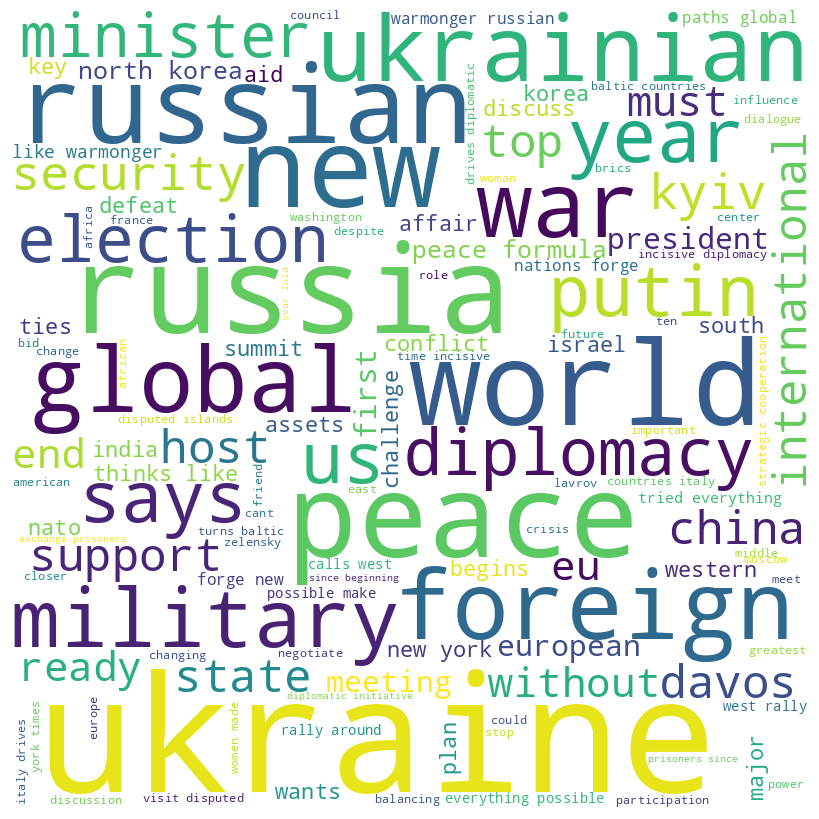

In [ ]:
wordcloud_generate(df['processed_text'][df['sentiment_label'] == 'POSITIVE'])

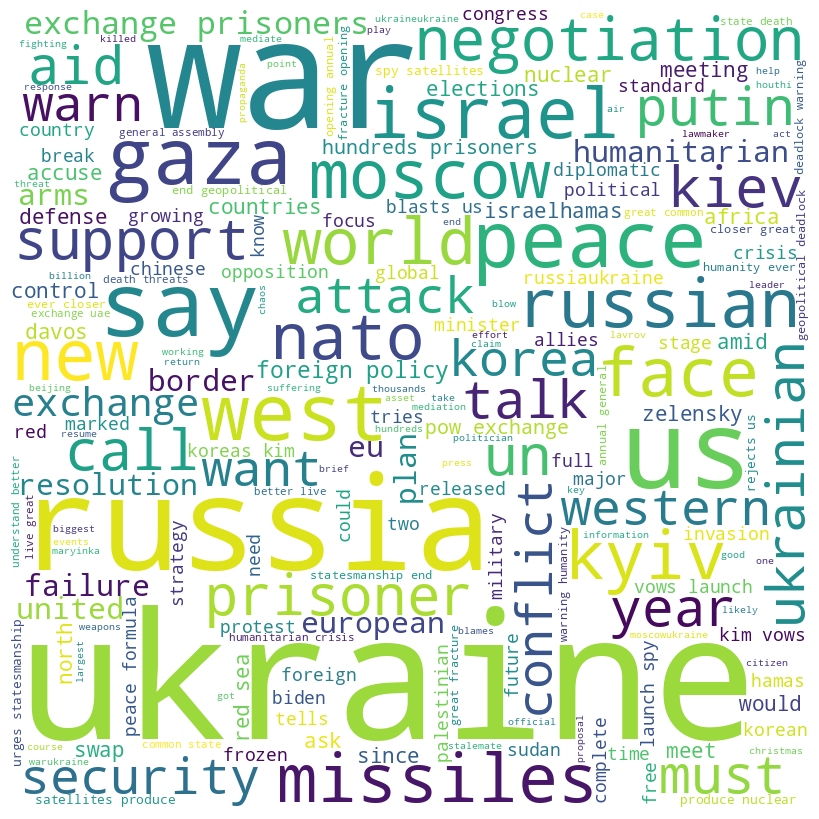

In [ ]:
wordcloud_generate(df['processed_text'][df['sentiment_label'] == 'NEGATIVE'])

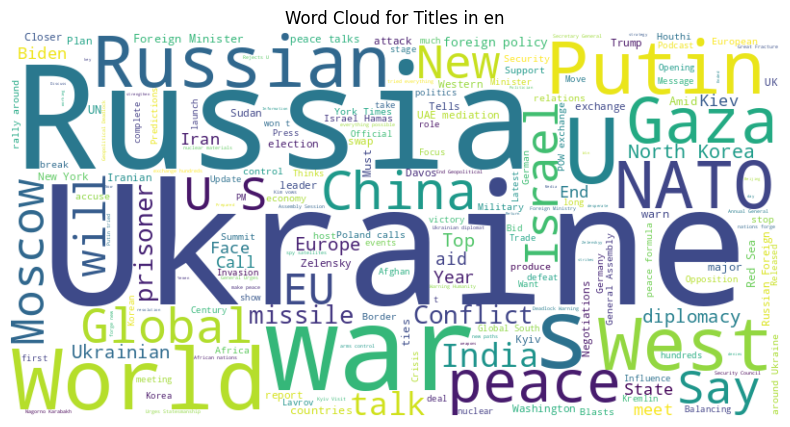

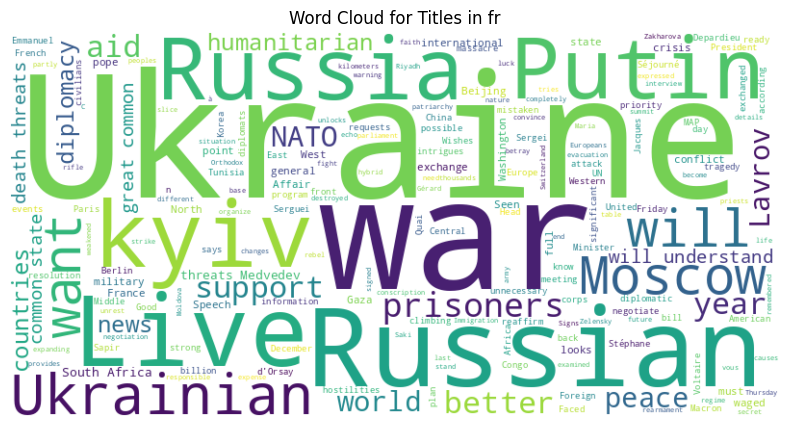

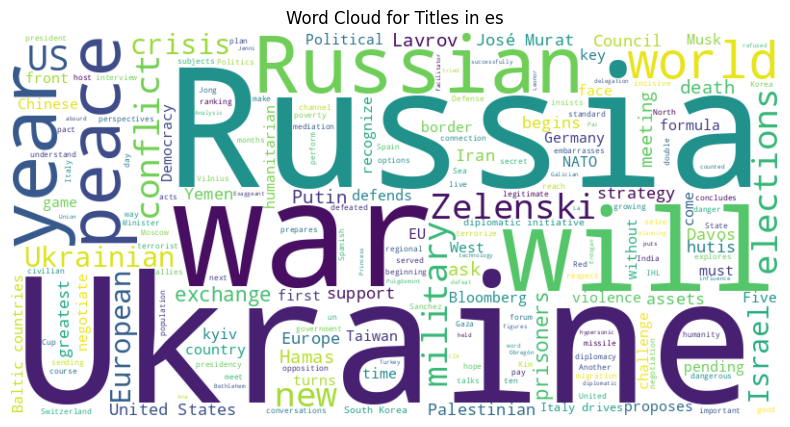

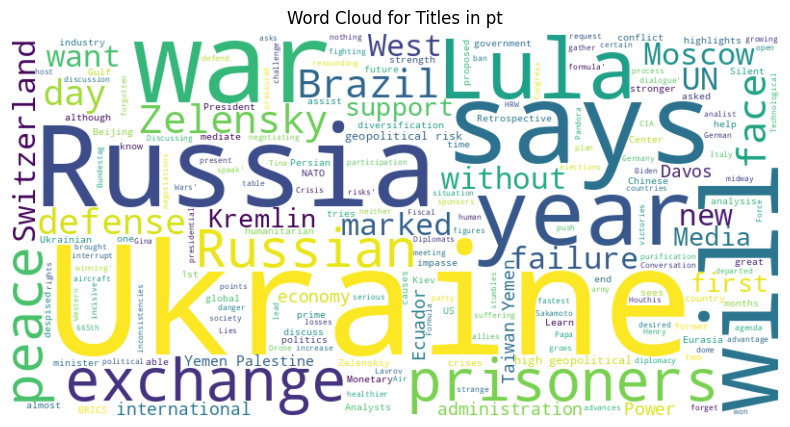

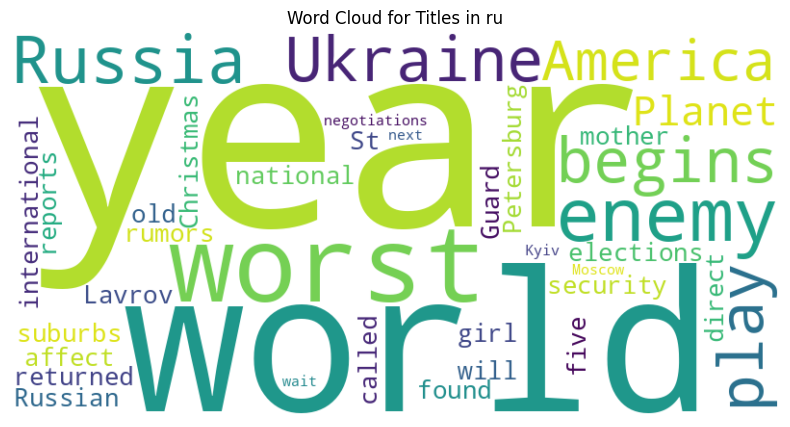

In [ ]:
from collections import defaultdict
from wordcloud import WordCloud

# Create a dictionary to store titles by language
titles_by_language = defaultdict(list)

# Iterate through the DataFrame and group titles by language
for index, row in df.iterrows():
    language = row['language']
    title = row['title']
    titles_by_language[language].append(title)

# Create word clouds for each language
for language, titles in titles_by_language.items():
    # Combine titles into a single string
    text = ' '.join(filter(None, titles))

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Titles in {language}')
    plt.axis('off')
    plt.show()

In [ ]:
# Assuming df has 'title', 'language', 'sentiment_label', and 'processed_text' columns
# Adjust column names as needed

# Create new columns indicating whether the article mentions "Russia" or "Ukraine"
df['mentions_russia'] = df['processed_text'].str.lower().str.contains('russia')
df['mentions_ukraine'] = df['processed_text'].str.lower().str.contains('ukraine')

# Group by 'language', 'sentiment_label', and 'mentions_russia', and count the occurrences
articles_count_by_language_and_sentiment_russia = df.groupby(['language', 'sentiment_label', 'mentions_russia']).size().unstack(fill_value=0)

# Group by 'language', 'sentiment_label', and 'mentions_ukraine', and count the occurrences
articles_count_by_language_and_sentiment_ukraine = df.groupby(['language', 'sentiment_label', 'mentions_ukraine']).size().unstack(fill_value=0)

# Display the tables
print("Articles Mentioning Russia:")
print(articles_count_by_language_and_sentiment_russia)

print("\nArticles Mentioning Ukraine:")
print(articles_count_by_language_and_sentiment_ukraine)


Articles Mentioning Russia:
mentions_russia           False  True 
language sentiment_label              
en       NEGATIVE           170     79
         POSITIVE           117     42
es       NEGATIVE            42     17
         POSITIVE            39     18
fr       NEGATIVE            40     10
         POSITIVE            27      7
pt       NEGATIVE            29     12
         POSITIVE            19      7
ru       NEGATIVE             2      2
         POSITIVE             1      0

Articles Mentioning Ukraine:
mentions_ukraine          False  True 
language sentiment_label              
en       NEGATIVE           160     89
         POSITIVE           118     41
es       NEGATIVE            43     16
         POSITIVE            44     13
fr       NEGATIVE            29     21
         POSITIVE            24     10
pt       NEGATIVE            20     21
         POSITIVE            18      8
ru       NEGATIVE             3      1
         POSITIVE             1      0
